In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
import visualkeras

from fastDamerauLevenshtein import damerauLevenshtein
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from tensorflow.keras import layers
from tqdm import trange

In [4]:
df = pd.read_csv('data/single_step_df_ints_2022-10-11_encoded.csv', header=0)

In [5]:
df

,input,target,start_coords.x,start_coords.y,start_coords.z,4.already_seen,bowl_1.already_seen,k.already_seen,dish_3.already_seen,c.already_seen,...,dish_3.food_k,dish_3.strong_k,dish_3.mid_k,coordinates_9.x,coordinates_9.y,coordinates_9.z,9.containment,9.food_k,9.strong_k,9.mid_k
0,<start>,p,-0.451354,-0.413918,0.156247,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p,o,0.513000,-0.531000,0.740000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,o,c,0.513000,-0.531000,0.740000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,c,g,0.513000,-0.531000,0.740000,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,g,k,0.513000,-0.531000,0.740000,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,2,3,2.500000,4.500000,2.000000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2199,3,4,2.500000,4.500000,2.000000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2200,4,5,2.500000,4.500000,2.000000,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2201,5,6,2.500000,4.500000,2.000000,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
float_cols = df.select_dtypes(include=['float64']).columns
df.loc[:, float_cols] = df.loc[:, float_cols].fillna(-99)

In [7]:
cols = df.select_dtypes(include=['object'])
for col in cols.columns.values:
    df[col] = df[col].fillna('')

In [8]:
df['target'].value_counts()
df[:1437]['target'].value_counts()
#df[:1437]['target'].loc[df[:1437]['target'] == 'i'].index[0]
#df_new[1436:]['target'].value_counts()

p    188
k    162
g    160
f    157
c    148
s    134
b     78
w     74
o     73
a     72
r     47
d     27
h     27
t     22
e     22
z     21
m     13
n      9
x      2
i      1
Name: target, dtype: int64

In [9]:
#index_to_drop = df[1436:]['target'].loc[df[1436:]['target'] == 'y'].index[0]
#index_to_drop2 = df[1436:]['target'].loc[df[1436:]['target'] == 'h'].index[0]
index_to_drop = df['target'].loc[df['target'] == 'i'].index[0]
index_to_drop

727

In [12]:
index_to_drop2 = df_new[:1437]['target'].loc[df_new[:1437]['target'] == 'i'].index[0]
index_to_drop2

727

In [10]:
nr_of_sequences = len(df[df['input'] == '<start>'])

In [11]:
# remove row with target that only occurs once

df_new = df.drop(index=[index_to_drop], axis=0)
#df_new = df.drop(index=[index_to_drop2], axis=0)
df_new.reset_index(inplace=True, drop=True)

In [12]:
# generate stratified split

split = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

for train_index, test_index in split.split(df_new[:1436], df_new[:1436]['target']):
#for train_index, test_index in split.split(df_new, df_new['target']):
#for train_index, test_index in split.split(df_new[1436:], df_new[1436:]['target']):
    strat_train = df_new.loc[train_index]
    strat_test_val = df_new.loc[test_index]

In [13]:
# split test_val into test and val

split_test_val = len(strat_test_val)//2

strat_test = strat_test_val[:split_test_val]
strat_val = strat_test_val[split_test_val:]

In [14]:
# generate list of labels to pass to MultiLabelBinarizer so there's the same number of
# classes for all datasets

labels = df_new['target'].unique()

In [15]:
len(labels)

35

In [16]:
def create_dataset(dataframe, labels, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels_ds = df.pop('target')
    encoder = MultiLabelBinarizer(classes=labels)
    encoded_labels = encoder.fit_transform(labels_ds)
    
    df = {key: value[:, tf.newaxis] for key, value in df.items()}
    dataset = tf.data.Dataset.from_tensor_slices((dict(df), encoded_labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(batch_size)
    
    return dataset

In [17]:
batch_size = 128

In [18]:
train_ds = create_dataset(strat_train, labels, batch_size=batch_size)
val_ds = create_dataset(strat_val, labels, shuffle=False, batch_size=batch_size)
test_ds = create_dataset(strat_test, labels, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_16211/1510453973.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in df.items()}


In [19]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
    normalizer.adapt(feature_ds)
    
    return normalizer

In [20]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
        
    # prepare tf.data.Dataset that only yields the feature    
    feature_ds = dataset.map(lambda x, y: x[name])
    
    # learn set of possible values and assign fixed int index
    index.adapt(feature_ds)
    
    # encode int indices
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    
    # apply multi-hot encoding to indices
    # lambda function captures the layer to include them in Keras functional models later
    return lambda feature: encoder(index(feature))

In [21]:
def create_input_data(dataframe):
    all_inputs = []
    encoded_features = []
    
    for header in dataframe.columns:
        # numerical features
        if 'coord' in header or 'already' in header:
            numeric_col = tf.keras.Input(shape=(1,), name=header)
            normalization_layer = get_normalization_layer(header, train_ds)
            encoded_numeric_col = normalization_layer(numeric_col)
            all_inputs.append(numeric_col)
            encoded_features.append(encoded_numeric_col)
        
        # categorical features
        elif 'containment' in header or 'food' in header or 'mid' in header or \
        'strong' in header:
            categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
            encoding_layer = get_category_encoding_layer(name=header,
                                                        dataset=train_ds,
                                                        dtype='int64')
            encoded_categorical_col = encoding_layer(categorical_col)
            all_inputs.append(categorical_col)
            encoded_features.append(encoded_categorical_col)
            
        elif header == 'input':
            categorical_col = tf.keras.Input(shape=(1,), name='input', dtype='string')
            encoding_layer = get_category_encoding_layer(name='input',
                                                        dataset=train_ds,
                                                        dtype='string')
            encoded_categorical_col = encoding_layer(categorical_col)
            all_inputs.append(categorical_col)
            encoded_features.append(encoded_categorical_col)
            
    return all_inputs, encoded_features

In [22]:
all_inputs, encoded_features = create_input_data(df)

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [24]:
# create model

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(512, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(len(labels))(x)

model = tf.keras.Model(all_inputs, output)

In [25]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [27]:
all_features

<KerasTensor: shape=(None, 645) dtype=float32 (created by layer 'concatenate')>

In [31]:
model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[callback])

Epoch 1/100
8/8 [==============================] - 11s 552ms/step - loss: 3.1714 - accuracy: 0.1114 - val_loss: 12275.9863 - val_accuracy: 0.1713
Epoch 2/100
8/8 [==============================] - 1s 65ms/step - loss: 2.5993 - accuracy: 0.1562 - val_loss: 13156.1074 - val_accuracy: 0.2685
Epoch 3/100
8/8 [==============================] - 1s 63ms/step - loss: 2.4086 - accuracy: 0.1781 - val_loss: 14069.5674 - val_accuracy: 0.2500
Epoch 4/100
8/8 [==============================] - 1s 62ms/step - loss: 2.2676 - accuracy: 0.2129 - val_loss: 13795.6113 - val_accuracy: 0.3287
Epoch 5/100
8/8 [==============================] - 1s 63ms/step - loss: 2.1894 - accuracy: 0.2328 - val_loss: 14478.3838 - val_accuracy: 0.3333
Epoch 6/100
8/8 [==============================] - 1s 63ms/step - loss: 2.0761 - accuracy: 0.2458 - val_loss: 14397.9980 - val_accuracy: 0.3519
Epoch 7/100
8/8 [==============================] - 1s 62ms/step - loss: 2.0356 - accuracy: 0.2667 - val_loss: 14864.8057 - val_accurac

8/8 [==============================] - 1s 62ms/step - loss: 1.1246 - accuracy: 0.6010 - val_loss: 23301.9824 - val_accuracy: 0.6111
Epoch 58/100
8/8 [==============================] - 1s 64ms/step - loss: 1.1295 - accuracy: 0.5940 - val_loss: 22431.2168 - val_accuracy: 0.5741
Epoch 59/100
8/8 [==============================] - 1s 62ms/step - loss: 1.1075 - accuracy: 0.6020 - val_loss: 21800.4102 - val_accuracy: 0.5787
Epoch 60/100
8/8 [==============================] - 1s 62ms/step - loss: 1.1159 - accuracy: 0.6060 - val_loss: 22892.1777 - val_accuracy: 0.5648
Epoch 61/100
8/8 [==============================] - 1s 63ms/step - loss: 1.1226 - accuracy: 0.5980 - val_loss: 22629.7520 - val_accuracy: 0.5648
Epoch 62/100
8/8 [==============================] - 1s 62ms/step - loss: 1.0772 - accuracy: 0.6149 - val_loss: 23362.6250 - val_accuracy: 0.5787
Epoch 63/100
8/8 [==============================] - 1s 63ms/step - loss: 1.0805 - accuracy: 0.6070 - val_loss: 23020.9121 - val_accuracy: 0.597

In [32]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 41ms/step - loss: 21935.1367 - accuracy: 0.5070
Accuracy 0.5069767236709595


In [41]:
model.save('models/next_obj_classifier_tablesetting_2022-10-11')

2022-10-11 10:48:07.300508: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/next_obj_classifier_tablesetting_2022-10-11/assets


INFO:tensorflow:Assets written to: models/next_obj_classifier_tablesetting_2022-10-11/assets


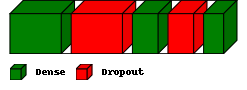

In [49]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, InputLayer, ZeroPadding2D
from collections import defaultdict
import visualkeras
#from PIL import ImageFont

# create VGG16
image_size = 224
model = Sequential()
model.add(InputLayer(input_shape=(10,10,3)))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

# Now visualize the model!

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'red'
color_map[MaxPooling2D]['fill'] = 'pink'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

#font = ImageFont.truetype("arial.ttf", 32)

visualkeras.layered_view(model, color_map=color_map, legend=True)